<a href="https://colab.research.google.com/github/WillKWL/Project-NBASeason/blob/master/1B_load_data_player%2Bteam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does performance in pre-all star season predict playoff ranking? 
- Supervised offline binary classification task with imbalanced data
- Performance measure: average precision (AUPRC)
- Data source: https://www.nba.com/stats/teams/traditional/?sort=W&dir=-1&Season=2021-22&SeasonType=Regular%20Season 
- By predicting the probability of winning the championship based on mid-season (defined as regular season pre all-star game) performance of the NBA teams performance in the regular season before the All-Star game, 
  - As fans, we can tell whether our favorite team has a high chance to win this year during the middle of the season
  - As coaching staff and team manager, we can tell if we need to make a change in our roster to increase our chances

In [2]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 11.8 MB/s 
  Created wheel for nba-api: filename=nba_api-1.1.11-py3-none-any.whl size=251504 sha256=04ec796c3c3cc16f921f453664a5f4aafd8644a5086ab4a77c2ae8eaa6254f46
  Stored in directory: /root/.cache/pip/wheels/e3/f4/46/996128675381abc175e306642bae575d372dcf7efc4683e551
Successfully built nba-api


In [3]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashteamstats, leaguedashplayerstats, leagueplayerondetails
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import os
from tqdm import tqdm
import numpy as np
from zlib import crc32
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
from google.colab import drive

In [4]:
# save to google drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

Mounted at /content/drive


# Gather data with [nba api](https://github.com/swar/nba_api)
- stats adjusted per 100 posessions, instead of per game, to account for the different pace each team plays at
- [glossary](https://www.nba.com/stats/help/glossary/) for column names  
- extra data: [advanced team stats](https://www.nba.com/stats/teams/advanced/?sort=W&dir=-1) 



In [ ]:
per_mode = 'Per100Possessions'

def get_team_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashteamstats.md
  return leaguedashteamstats.LeagueDashTeamStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

def get_player_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashplayerstats.md
  return leaguedashplayerstats.LeagueDashPlayerStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

In [ ]:
season = '2021-22'
try:
  player_df = get_player_table("Base", season, "Regular Season", "Pre All-Star")
  print("Base")
  print(player_df.column.values)
except:
  print(f"error at Base {season} player")
list_of_measures = ["Advanced", "Misc", "Scoring", "Defense"]
for measure in list_of_measures:
  try:
    result_df = get_player_table(measure, season, "Regular Season", "Pre All-Star")
    print(measure)
    print(result_df.columns.difference(player_df.columns).tolist())
    # print(f"{measure} success")
    player_df = player_df.merge(
      result_df[['PLAYER_ID'] + result_df.columns.difference(player_df.columns).tolist()], # only keep the unique columns + PLAYER_ID
      on = "PLAYER_ID", how = "inner", suffixes = ("", "_y"))
  except: 
    print(f"error at {measure} {season} player")

remaining_col = [x for x in player_df.columns if 
                (re.search('_FANTASY_PTS$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                (re.search('_RANK$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                (re.search('^E_\w+', x) is None) &   # remove columns starting with E_ (unknown estimates provided by NBA)
                (re.search('^sp_work_\w+', x) is None) &     # remove columns starting with sp_work_ (unknown estimates provided by NBA)
                (re.search('DEF_WS', x) is None)     # remove columns starting with sp_work_ (unknown estimates provided by NBA)
                ]
try:
  player_df = player_df[remaining_col]
except:
  print(f"error at player {season}")

Base
error at Base 2021-22 player
Advanced
['AST_PCT', 'AST_PCT_RANK', 'AST_RATIO', 'AST_RATIO_RANK', 'AST_TO', 'AST_TO_RANK', 'DEF_RATING', 'DEF_RATING_RANK', 'DREB_PCT', 'DREB_PCT_RANK', 'EFG_PCT', 'EFG_PCT_RANK', 'E_DEF_RATING', 'E_DEF_RATING_RANK', 'E_NET_RATING', 'E_NET_RATING_RANK', 'E_OFF_RATING', 'E_OFF_RATING_RANK', 'E_PACE', 'E_PACE_RANK', 'E_TOV_PCT', 'E_TOV_PCT_RANK', 'E_USG_PCT', 'E_USG_PCT_RANK', 'FGA_PG', 'FGA_PG_RANK', 'FGM_PG', 'FGM_PG_RANK', 'NET_RATING', 'NET_RATING_RANK', 'OFF_RATING', 'OFF_RATING_RANK', 'OREB_PCT', 'OREB_PCT_RANK', 'PACE', 'PACE_PER40', 'PACE_RANK', 'PIE', 'PIE_RANK', 'POSS', 'REB_PCT', 'REB_PCT_RANK', 'TM_TOV_PCT', 'TM_TOV_PCT_RANK', 'TS_PCT', 'TS_PCT_RANK', 'USG_PCT', 'USG_PCT_RANK', 'sp_work_DEF_RATING', 'sp_work_DEF_RATING_RANK', 'sp_work_NET_RATING', 'sp_work_NET_RATING_RANK', 'sp_work_OFF_RATING', 'sp_work_OFF_RATING_RANK', 'sp_work_PACE', 'sp_work_PACE_RANK']
Misc
['OPP_PTS_2ND_CHANCE', 'OPP_PTS_2ND_CHANCE_RANK', 'OPP_PTS_FB', 'OPP_PTS_FB_RA

In [ ]:
def season_vs_playoff(start_year, end_year):
  output = None
  season_list = [str(i) + '-' + str(i+1)[2:] for i in range(start_year, end_year)]
  with tqdm(total=len(season_list)) as pbar:
    for season in season_list:
      
      # df for player stats
      try:
        player_df = get_player_table("Base", season, "Regular Season", "Pre All-Star")
      except:
        print(f"error at Base {season} player")
      list_of_measures = ["Advanced", "Misc", "Scoring", "Defense"]
      for measure in list_of_measures:
        try:
          result_df = get_player_table(measure, season, "Regular Season", "Pre All-Star")
          # print(f"{measure} success")
          player_df = player_df.merge(
            result_df[['PLAYER_ID'] + result_df.columns.difference(player_df.columns).tolist()], # only keep the unique columns + PLAYER_ID
            on = "PLAYER_ID", how = "inner", suffixes = ("", "_y"))
        except: 
          print(f"error at {measure} {season} player")

      remaining_col = [x for x in player_df.columns if 
                      (re.search('_FANTASY_PTS$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                      (re.search('_RANK$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                      (re.search('^E_\w+', x) is None) &   # remove columns starting with E_ (unknown estimates provided by NBA)
                      (re.search('^sp_work_\w+', x) is None) &     # remove columns starting with sp_work_ (unknown estimates provided by NBA)
                      (re.search('DEF_WS', x) is None)     # remove columns starting with sp_work_ (unknown estimates provided by NBA)
                      ]
      try:
        player_df = player_df[remaining_col]
      except:
        print(f"error at player {season}")

      # df for team stats
      try:
        team_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
      except:
        print(f"error at Base {season} team")
      list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
      for measure in list_of_measures:
        try:
          result_df = get_team_table(measure, season, "Regular Season", "Pre All-Star")
          # print(f"{measure} success")
          team_df = team_df.merge(
            result_df[['TEAM_ID'] + result_df.columns.difference(team_df.columns).tolist()], # only keep the unique columns + TEAM_ID
            on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))
        except: 
          print(f"error at {measure} {season} team")

      remaining_col = [x for x in team_df.columns if 
                      (re.search('_RANK$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                      (re.search('^E_\w+', x) is None)     # remove columns starting with E_ (unknown estimates provided by NBA)
                      ]
      try:
        team_df = team_df[remaining_col]
      except:
        print(f"error at team {season}")

      try:
        player_df.columns = player_df.columns + ['_P']
        team_df.columns = team_df.columns + ['_T']
        season_df = player_df.merge(team_df, how='left', left_on='TEAM_ID_P', right_on='TEAM_ID_T')

        playoff_df = get_team_table("Base", season, "Playoffs")
        
        # winning championship = 1, else = 0
        playoff_df = playoff_df.loc[playoff_df['W'] == playoff_df['W'].max()]
        playoff_df[['PLAYOFF_RANKING']] = 1

        playoff_df = playoff_df[['TEAM_ID', 'PLAYOFF_RANKING']] 

        season_vs_playoff = pd.merge(season_df, playoff_df, left_on='TEAM_ID_T', right_on='TEAM_ID', how = 'left')
        season_vs_playoff.fillna(0, inplace=True) # teams which are not in playoff will have 0 as PLAYOFF_RANKING
        season_vs_playoff['PLAYOFF_RANKING'] = season_vs_playoff['PLAYOFF_RANKING'].astype(int)
        season_vs_playoff['SEASON'] = season
        output = pd.concat([output,season_vs_playoff.sort_values(by='PLAYOFF_RANKING', ascending = False).reset_index(drop=True)], axis = 0)

      except:
        print(f"error at {season}")

      pbar.update(1)
  
  return output

In [ ]:
df = season_vs_playoff(start_year = 1996, end_year = 2022)
df

100%|██████████| 26/26 [06:49<00:00, 15.74s/it]


,PLAYER_ID_P,PLAYER_NAME_P,NICKNAME_P,TEAM_ID_P,TEAM_ABBREVIATION_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,CFPARAMS_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,TEAM_NAME_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,CFPARAMS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,PLAYOFF_RANKING,SEASON
0,82,Bill Wennington,Bill,1610612741,CHI,34.0,47,41,6,0.872,51.8,7.5,15.5,0.483,0.0,0.2,0.000,2.3,2.8,0.811,3.0,5.4,8.4,2.8,2.4,0.8,0.8,0.6,8.6,0.0,17.3,7.2,1,0,5,"82,1610612741",0.079,12.5,1.16,99.5,0.105,0.483,4.3,2.1,8.3,107.7,0.058,93.11,77.59,0.049,1308,0.082,10.8,0.515,0.163,14.4,12.8,15.5,43.0,3.8,0.9,2.3,4.0,0.888,0.000,0.888,0.990,0.010,0.867,0.637,0.000,0.053,0.133,0.133,0.230,0.112,0.000,0.112,0.196,0.169,0.093,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1.610613e+09,1,1996-97
1,679,Jason Caffey,Jason,1610612741,CHI,24.0,41,35,6,0.854,51.9,8.2,14.7,0.556,0.0,0.0,0.000,4.7,7.7,0.606,4.2,5.6,9.8,3.1,4.3,0.9,0.2,1.9,6.6,0.0,21.0,5.3,0,0,5,"679,1610612741",0.093,12.1,0.71,99.8,0.107,0.556,4.3,2.4,7.2,107.0,0.087,93.43,77.86,0.073,1213,0.097,16.9,0.581,0.191,16.7,10.6,16.3,40.7,3.8,3.3,5.0,12.0,0.677,0.000,0.677,1.000,0.000,0.776,0.204,0.000,0.157,0.224,0.239,0.573,0.323,0.000,0.323,0.070,0.187,0.095,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1.610613e+09,1,1996-97
2,893,Michael Jordan,Michael,1610612741,CHI,34.0,48,42,6,0.875,52.4,16.0,32.7,0.489,1.8,5.1,0.347,8.8,10.3,0.852,1.9,6.0,7.8,5.4,2.3,2.3,0.7,0.9,2.5,0.0,42.6,14.9,3,0,5,"893,1610612741",0.191,

In [ ]:
df.to_csv('nba_pre_all_star_vs_playoff_comprehensive_playerplusteam.csv', index = False)
# download local copy
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_comprehensive_playerplusteam.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
df = pd.read_csv('https://github.com/WillKWL/PublicData/raw/main/raw/nba_pre_all_star_vs_playoff_comprehensive_playerplusteam.csv')
df

,PLAYER_ID_P,PLAYER_NAME_P,NICKNAME_P,TEAM_ID_P,TEAM_ABBREVIATION_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,CFPARAMS_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,TEAM_NAME_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,CFPARAMS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,PLAYOFF_RANKING,SEASON
0,82,Bill Wennington,Bill,1610612741,CHI,34.0,47,41,6,0.872,51.8,7.5,15.5,0.483,0.0,0.2,0.000,2.3,2.8,0.811,3.0,5.4,8.4,2.8,2.4,0.8,0.8,0.6,8.6,0.0,17.3,7.2,1,0,5,"82,1610612741",0.079,12.5,1.16,99.5,0.105,0.483,4.3,2.1,8.3,107.7,0.058,93.11,77.59,0.049,1308,0.082,10.8,0.515,0.163,14.4,12.8,15.5,43.0,3.8,0.9,2.3,4.0,0.888,0.000,0.888,0.990,0.010,0.867,0.637,0.000,0.053,0.133,0.133,0.230,0.112,0.000,0.112,0.196,0.169,0.093,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1.610613e+09,1,1996-97
1,679,Jason Caffey,Jason,1610612741,CHI,24.0,41,35,6,0.854,51.9,8.2,14.7,0.556,0.0,0.0,0.000,4.7,7.7,0.606,4.2,5.6,9.8,3.1,4.3,0.9,0.2,1.9,6.6,0.0,21.0,5.3,0,0,5,"679,1610612741",0.093,12.1,0.71,99.8,0.107,0.556,4.3,2.4,7.2,107.0,0.087,93.43,77.86,0.073,1213,0.097,16.9,0.581,0.191,16.7,10.6,16.3,40.7,3.8,3.3,5.0,12.0,0.677,0.000,0.677,1.000,0.000,0.776,0.204,0.000,0.157,0.224,0.239,0.573,0.323,0.000,0.323,0.070,0.187,0.095,1610612741,Chicago Bulls,48,42,6,0.875,52.4,43.4,92.0,0.471,6.8,18.9,0.361,18.0,24.3,0.743,16.0,32.3,48.2,27.7,14.3,9.5,4.1,3.8,21.2,0.1,111.6,12.8,10,Chicago Bulls,0.640,19.0,1.94,98.7,0.671,0.508,12.9,111.6,0.362,91.56,76.30,0.592,4403,0.518,0.143,0.543,15.7,11.1,14.9,41.7,17.9,13.9,21.4,39.1,0.264,0.467,0.259,0.329,0.178,0.611,0.793,0.640,0.795,0.205,0.655,0.305,0.183,0.125,0.162,0.192,0.350,0.389,0.207,0.360,20.8,3.8,4.1,29.9,18.7,6.0,0.318,88.0,38.1,0.433,22.8,16.6,0.727,14.4,23.0,21.2,98.8,44.3,7.9,17.9,1.610613e+09,1,1996-97
2,893,Michael Jordan,Michael,1610612741,CHI,34.0,48,42,6,0.875,52.4,16.0,32.7,0.489,1.8,5.1,0.347,8.8,10.3,0.852,1.9,6.0,7.8,5.4,2.3,2.3,0.7,0.9,2.5,0.0,42.6,14.9,3,0,5,"893,1610612741",0.191,

In [31]:
pd.DataFrame(df.dtypes).T

,PLAYER_ID_P,PLAYER_NAME_P,NICKNAME_P,TEAM_ID_P,TEAM_ABBREVIATION_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,CFPARAMS_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,TEAM_NAME_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,CFPARAMS_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,PLAYOFF_RANKING,SEASON
0,int64,object,object,int64,object,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object


In [32]:
df.describe()

,PLAYER_ID_P,TEAM_ID_P,AGE_P,GP_P,W_P,L_P,W_PCT_P,MIN_P,FGM_P,FGA_P,FG_PCT_P,FG3M_P,FG3A_P,FG3_PCT_P,FTM_P,FTA_P,FT_PCT_P,OREB_P,DREB_P,REB_P,AST_P,TOV_P,STL_P,BLK_P,BLKA_P,PF_P,PFD_P,PTS_P,PLUS_MINUS_P,DD2_P,TD3_P,CFID_P,AST_PCT_P,AST_RATIO_P,AST_TO_P,DEF_RATING_P,DREB_PCT_P,EFG_PCT_P,FGA_PG_P,FGM_PG_P,NET_RATING_P,OFF_RATING_P,OREB_PCT_P,PACE_P,PACE_PER40_P,PIE_P,POSS_P,REB_PCT_P,TM_TOV_PCT_P,TS_PCT_P,USG_PCT_P,OPP_PTS_2ND_CHANCE_P,OPP_PTS_FB_P,OPP_PTS_OFF_TOV_P,OPP_PTS_PAINT_P,PTS_2ND_CHANCE_P,PTS_FB_P,PTS_OFF_TOV_P,PTS_PAINT_P,PCT_AST_2PM_P,PCT_AST_3PM_P,PCT_AST_FGM_P,PCT_FGA_2PT_P,PCT_FGA_3PT_P,PCT_PTS_2PT_P,PCT_PTS_2PT_MR_P,PCT_PTS_3PT_P,PCT_PTS_FB_P,PCT_PTS_FT_P,PCT_PTS_OFF_TOV_P,PCT_PTS_PAINT_P,PCT_UAST_2PM_P,PCT_UAST_3PM_P,PCT_UAST_FGM_P,PCT_BLK_P,PCT_DREB_P,PCT_STL_P,TEAM_ID_T,GP_T,W_T,L_T,W_PCT_T,MIN_T,FGM_T,FGA_T,FG_PCT_T,FG3M_T,FG3A_T,FG3_PCT_T,FTM_T,FTA_T,FT_PCT_T,OREB_T,DREB_T,REB_T,AST_T,TOV_T,STL_T,BLK_T,BLKA_T,PF_T,PFD_T,PTS_T,PLUS_MINUS_T,CFID_T,AST_PCT_T,AST_RATIO_T,AST_TO_T,DEF_RATING_T,DREB_PCT_T,EFG_PCT_T,NET_RATING_T,OFF_RATING_T,OREB_PCT_T,PACE_T,PACE_PER40_T,PIE_T,POSS_T,REB_PCT_T,TM_TOV_PCT_T,TS_PCT_T,OPP_PTS_2ND_CHANCE_T,OPP_PTS_FB_T,OPP_PTS_OFF_TOV_T,OPP_PTS_PAINT_T,PTS_2ND_CHANCE_T,PTS_FB_T,PTS_OFF_TOV_T,PTS_PAINT_T,FTA_RATE_T,OPP_EFG_PCT_T,OPP_FTA_RATE_T,OPP_OREB_PCT_T,OPP_TOV_PCT_T,PCT_AST_2PM_T,PCT_AST_3PM_T,PCT_AST_FGM_T,PCT_FGA_2PT_T,PCT_FGA_3PT_T,PCT_PTS_2PT_T,PCT_PTS_2PT_MR_T,PCT_PTS_3PT_T,PCT_PTS_FB_T,PCT_PTS_FT_T,PCT_PTS_OFF_TOV_T,PCT_PTS_PAINT_T,PCT_UAST_2PM_T,PCT_UAST_3PM_T,PCT_UAST_FGM_T,OPP_AST_T,OPP_BLK_T,OPP_BLKA_T,OPP_DREB_T,OPP_FG3A_T,OPP_FG3M_T,OPP_FG3_PCT_T,OPP_FGA_T,OPP_FGM_T,OPP_FG_PCT_T,OPP_FTA_T,OPP_FTM_T,OPP_FT_PCT_T,OPP_OREB_T,OPP_PF_T,OPP_PFD_T,OPP_PTS_T,OPP_REB_T,OPP_STL_T,OPP_TOV_T,TEAM_ID,PLAYOFF_RANKING
count,1.177100e+04,1.177100e+04,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.0,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,1.177100e+04,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.0,11771.000000,11771.000000,11771.000000,11771.000000,11771.00000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,11771.000000,1.177100e+04,11

# Remove outlier rows by GP

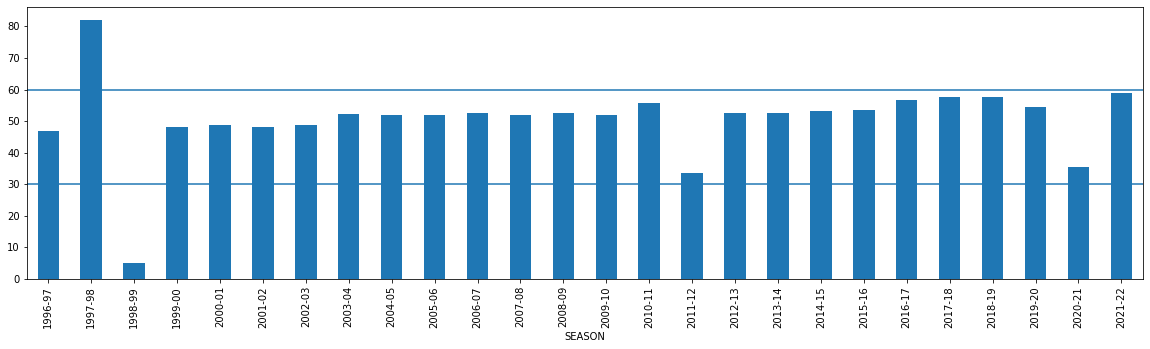

In [35]:
# consider removing outlier in terms of games played 
# since those records are not representative samples of mid-season performance
# 1997-98: 82 games played = whole season but not mid-season, 
  # all-star game was held in Feb (Kobe's debut for youngest all-star player)
  # season lasted from Oct to Apr
# 1998-89: see 1998 NBA lockout
  # < 10 games played = too small of a sample size to gauge mid-season performance
# 2011-12: see 2011 NBA lockout
# 2020-21: see postponed season due to COVID-19
df.groupby('SEASON').GP_T.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [36]:
# cannot pass this in sklearn pipeline so let's do it on dataset level
# both player and his team needs to play >= 30 games and <= 60 games such that we have a large enough sample to gauge mid-season performance
df = df.loc[((df.GP_P >= 30) & (df.GP_T >= 30)) & ((df.GP_P <= 60) & (df.GP_T <= 60))]

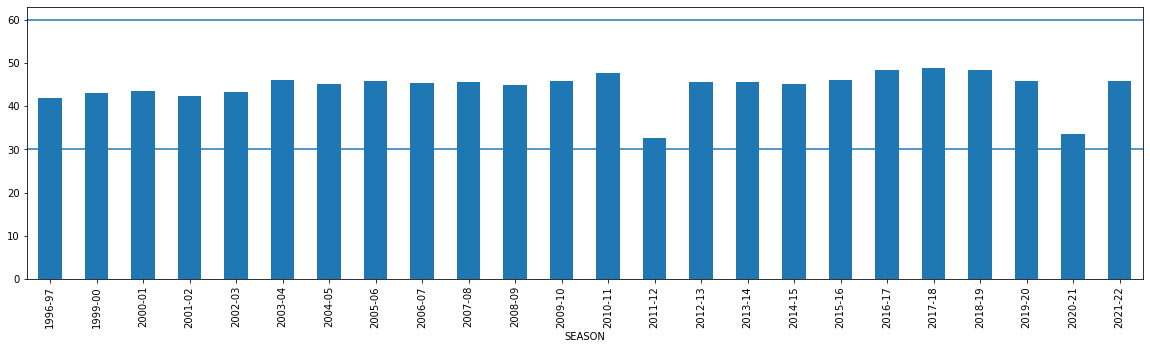

In [37]:
# now fixed
df.groupby('SEASON').GP_P.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [38]:
df.drop(columns=['TEAM_ID_P'], inplace=True)

# fix datatypes
for col in ['PLAYER_ID_P', 'PLAYER_NAME_P', 'NICKNAME_P', 'TEAM_ABBREVIATION_P',
            'CFID_P', 'CFPARAMS_P', 'TEAM_NAME_T', 'CFID_T', 'CFPARAMS_T', 'TEAM_ID_T', 'TEAM_ID']:
  df.loc[:, col] = df[col].astype(str)

df.loc[:, 'PLAYOFF_RANKING'] = df['PLAYOFF_RANKING'].astype('category')
df.loc[:, 'SEASON'] = df['SEASON'].astype('category')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7124 entries, 0 to 11769
Columns: 177 entries, PLAYER_ID_P to SEASON
dtypes: category(2), float64(154), int64(10), object(11)
memory usage: 9.6+ MB


In [40]:
# check only 1 winner in each year
pd.DataFrame(df[df.PLAYOFF_RANKING == 1].groupby(['SEASON']).TEAM_NAME_T.unique())

,TEAM_NAME_T
SEASON,
1996-97,[Chicago Bulls]
1999-00,[Los Angeles Lakers]
2000-01,[Los Angeles Lakers]
2001-02,[Los Angeles Lakers]
2002-03,[San Antonio Spurs]
...,...
2017-18,[Golden State Warriors]
2018-19,[Toronto Raptors]
2019-20,[Los Angeles Lakers]


# Check numeric columns

In [41]:
sorted(df.select_dtypes(include=np.number).columns.values)

['AGE_P',
 'AST_P',
 'AST_PCT_P',
 'AST_PCT_T',
 'AST_RATIO_P',
 'AST_RATIO_T',
 'AST_T',
 'AST_TO_P',
 'AST_TO_T',
 'BLKA_P',
 'BLKA_T',
 'BLK_P',
 'BLK_T',
 'DD2_P',
 'DEF_RATING_P',
 'DEF_RATING_T',
 'DREB_P',
 'DREB_PCT_P',
 'DREB_PCT_T',
 'DREB_T',
 'EFG_PCT_P',
 'EFG_PCT_T',
 'FG3A_P',
 'FG3A_T',
 'FG3M_P',
 'FG3M_T',
 'FG3_PCT_P',
 'FG3_PCT_T',
 'FGA_P',
 'FGA_PG_P',
 'FGA_T',
 'FGM_P',
 'FGM_PG_P',
 'FGM_T',
 'FG_PCT_P',
 'FG_PCT_T',
 'FTA_P',
 'FTA_RATE_T',
 'FTA_T',
 'FTM_P',
 'FTM_T',
 'FT_PCT_P',
 'FT_PCT_T',
 'GP_P',
 'GP_T',
 'L_P',
 'L_T',
 'MIN_P',
 'MIN_T',
 'NET_RATING_P',
 'NET_RATING_T',
 'OFF_RATING_P',
 'OFF_RATING_T',
 'OPP_AST_T',
 'OPP_BLKA_T',
 'OPP_BLK_T',
 'OPP_DREB_T',
 'OPP_EFG_PCT_T',
 'OPP_FG3A_T',
 'OPP_FG3M_T',
 'OPP_FG3_PCT_T',
 'OPP_FGA_T',
 'OPP_FGM_T',
 'OPP_FG_PCT_T',
 'OPP_FTA_RATE_T',
 'OPP_FTA_T',
 'OPP_FTM_T',
 'OPP_FT_PCT_T',
 'OPP_OREB_PCT_T',
 'OPP_OREB_T',
 'OPP_PFD_T',
 'OPP_PF_T',
 'OPP_PTS_2ND_CHANCE_P',
 'OPP_PTS_2ND_CHANCE_T',
 'OPP_P

# Train test split with unique identifier = TEAM_ID + SEASON
- hashing unique identifier
- alternative: stratified sampling by season

In [42]:
# unique id = team id + season
# if you use player id instead, there will be data leakage as player A and B on the same winning team can go into train and test set
df.loc[:, 'UNIQUE_ID'] = df['TEAM_ID_T'].astype(str) + df['SEASON'].str.replace('-','')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [43]:
# instead of train-test_split by random shuffling, hash the unique identifier for train-test split
# slight modification to the technique from Hands On Machine Learning by Aurélien Géron
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  threshold = np.quantile(ids.apply(lambda x: crc32(np.int64(x))), test_ratio) # instead of using test_ratio * 2**32 as the threshold, this is more accurate
  in_test_set = ids.apply(lambda x: crc32(np.int64(x)) < threshold) 
  return data.loc[~in_test_set], data.loc[in_test_set]

In [44]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "UNIQUE_ID")

In [45]:
print(f"size of full dataset: {df.shape}")
print(f"size of train dataset: {train_set.shape}")
print(f"size of test dataset: {test_set.shape}")
print(f"train-test ratio: {train_set.shape[0] / df.shape[0]:0.2} / {test_set.shape[0] / df.shape[0]:0.2}")

size of full dataset: (7124, 178)
size of train dataset: (5701, 178)
size of test dataset: (1423, 178)
train-test ratio: 0.8 / 0.2


In [46]:
# save to google drive
os.chdir('/content/drive/MyDrive/Colab Notebooks')
train_set.to_pickle('nba_pre_all_star_vs_playoff_train_comprehensive_playerplusteam.pkl')
test_set.to_pickle('nba_pre_all_star_vs_playoff_test_comprehensive_playerplusteam.pkl')

# download local copy to push to github
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_train_comprehensive_playerplusteam.pkl")
files.download("nba_pre_all_star_vs_playoff_test_comprehensive_playerplusteam.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# explanatory variable (Y) = PLAYOFF_RANKING
pd.read_pickle("https://github.com/WillKWL/PublicData/blob/main/raw/nba_pre_all_star_vs_playoff_train_comprehensive_playerplusteam.pkl?raw=true").groupby(["SEASON"]).PLAYOFF_RANKING.value_counts().reset_index().pivot(index = "level_1", columns = "SEASON", values = "PLAYOFF_RANKING")

SEASON,1996-97,1999-00,2000-01,2001-02,2002-03,2003-04,2004-05,2005-06,2006-07,2007-08,2008-09,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2021-22
level_1,,,,,,,,,,,,,,,,,,,,,,,,
0,224,215,220,240,218,227,246,213,228,231,210,208,248,139,224,234,284,276,251,227,255,260,149,266
1,10,11,0,11,11,0,12,9,11,0,12,11,11,7,11,13,10,12,13,0,0,13,8,12
